# 性别预测任务

## 导入库和基础组件

In [1]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import itertools
import collections
import matplotlib.pyplot as plt
import math

# 位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-math.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

# 测试位置编码
print("测试位置编码:")
pe = PositionalEncoding(embed_size=8, max_len=10)
test_input = torch.randn(2, 5, 8)  # (batch_size=2, seq_len=5, embed_size=8)
output = pe(test_input)
print(f"输入形状: {test_input.shape}")
print(f"输出形状: {output.shape}")
print(f"位置编码是否成功添加: {torch.any(output != test_input)}")

测试位置编码:
输入形状: torch.Size([2, 5, 8])
输出形状: torch.Size([2, 5, 8])
位置编码是否成功添加: True


## 多头自注意力机制

In [2]:
# 多头自注意力机制
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads, qk_dim):
        super().__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim_qk = qk_dim // heads
        self.head_dim_v = embed_size // heads

        assert qk_dim % heads == 0, "qk_dim 必须能被 heads 整除"
        assert embed_size % heads == 0, "embed_size 必须能被 heads 整除"

        self.query = nn.Linear(embed_size, qk_dim)
        self.key = nn.Linear(embed_size, qk_dim)
        self.value = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, query, key=None, value=None, mask=None):
        if key is None:
            key = query
        if value is None:
            value = query

        N = query.shape[0]
        query_len = query.shape[1]
        key_len = key.shape[1]
        value_len = value.shape[1]

        Q = self.query(query)
        K = self.key(key)
        V = self.value(value)

        Q = Q.view(N, query_len, self.heads, self.head_dim_qk).transpose(1, 2)
        K = K.view(N, key_len, self.heads, self.head_dim_qk).transpose(1, 2)
        V = V.view(N, value_len, self.heads, self.head_dim_v).transpose(1, 2)

        energy = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self.head_dim_qk)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy, dim=-1)
        out = torch.matmul(attention, V)
        out = out.transpose(1, 2).contiguous().view(N, query_len, self.embed_size)
        out = self.fc_out(out)

        return out

# 测试多头自注意力
print("测试多头自注意力:")
attention = SelfAttention(embed_size=8, heads=4, qk_dim=8)
test_input = torch.randn(2, 5, 8)  # (batch_size=2, seq_len=5, embed_size=8)
output = attention(test_input)
print(f"输入形状: {test_input.shape}")
print(f"输出形状: {output.shape}")
print(f"注意力机制是否正常工作: {output.shape == test_input.shape}")

测试多头自注意力:
输入形状: torch.Size([2, 5, 8])
输出形状: torch.Size([2, 5, 8])
注意力机制是否正常工作: True


## 前馈神经网络和Encoder Block

In [3]:
# 前馈神经网络
class FeedForward(nn.Module):
    def __init__(self, embed_size, hidden_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embed_size, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Encoder Block
class EncoderBlock(nn.Module):
    def __init__(self, embed_size, heads, qk_dim, ffn_hidden, dropout=0.1):
        super().__init__()
        self.attention = SelfAttention(embed_size, heads, qk_dim)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.ffn = FeedForward(embed_size, ffn_hidden, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_out = self.attention(query=x, mask=mask)
        x = self.norm1(x + self.dropout(attn_out))
        ffn_out = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_out))
        return x

# 测试前馈网络和Encoder Block
print("测试前馈网络:")
ffn = FeedForward(embed_size=8, hidden_dim=16, dropout=0.1)
test_input = torch.randn(2, 5, 8)
output = ffn(test_input)
print(f"前馈网络输入形状: {test_input.shape}")
print(f"前馈网络输出形状: {output.shape}")

print("\n测试Encoder Block:")
encoder_block = EncoderBlock(embed_size=8, heads=4, qk_dim=8, ffn_hidden=16, dropout=0.1)
test_input = torch.randn(2, 5, 8)
output = encoder_block(test_input)
print(f"Encoder Block输入形状: {test_input.shape}")
print(f"Encoder Block输出形状: {output.shape}")

测试前馈网络:
前馈网络输入形状: torch.Size([2, 5, 8])
前馈网络输出形状: torch.Size([2, 5, 8])

测试Encoder Block:
Encoder Block输入形状: torch.Size([2, 5, 8])
Encoder Block输出形状: torch.Size([2, 5, 8])


##  Transformer Encoder和性别分类器

In [4]:
# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_layers, heads, qk_dim,
                 ff_hidden_size, dropout=0.1, max_length=100):
        super().__init__()
        self.embed_size = embed_size
        
        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_encoding = PositionalEncoding(embed_size, max_length)
        
        self.layers = nn.ModuleList([
            EncoderBlock(embed_size, heads, qk_dim, ff_hidden_size, dropout)
            for _ in range(num_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        out = self.word_embedding(x)
        out = self.position_encoding(out)
        out = self.dropout(out)

        for layer in self.layers:
            out = layer(out, mask)

        return out

# 性别分类器
class GenderClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, num_layers, heads, qk_dim, 
                 ff_hidden_size, dropout=0.1, max_length=100):
        super().__init__()
        self.transformer = TransformerEncoder(
            vocab_size, embed_size, num_layers, heads, qk_dim, 
            ff_hidden_size, dropout, max_length
        )
        self.classifier = nn.Sequential(
            nn.Linear(embed_size, embed_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_size // 2, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, mask=None):
        # x: (N, seq_len)
        encoded = self.transformer(x, mask)  # (N, seq_len, embed_size)
        # 取序列的平均值作为特征
        pooled = torch.mean(encoded, dim=1)  # (N, embed_size)
        output = self.classifier(pooled)  # (N, 1)
        return output

# 测试Transformer Encoder和性别分类器
print("测试Transformer Encoder:")
encoder = TransformerEncoder(vocab_size=100, embed_size=8, num_layers=2, heads=4, 
                           qk_dim=8, ff_hidden_size=16, dropout=0.1, max_length=10)
test_input = torch.randint(0, 100, (2, 5))  # (batch_size=2, seq_len=5)
output = encoder(test_input)
print(f"Encoder输入形状: {test_input.shape}")
print(f"Encoder输出形状: {output.shape}")

print("\n测试性别分类器:")
classifier = GenderClassifier(vocab_size=100, embed_size=8, num_layers=2, heads=4, 
                            qk_dim=8, ff_hidden_size=16, dropout=0.1, max_length=10)
test_input = torch.randint(0, 100, (2, 5))
output = classifier(test_input)
print(f"分类器输入形状: {test_input.shape}")
print(f"分类器输出形状: {output.shape}")
print(f"输出值范围: [{output.min().item():.4f}, {output.max().item():.4f}]")

测试Transformer Encoder:
Encoder输入形状: torch.Size([2, 5])
Encoder输出形状: torch.Size([2, 5, 8])

测试性别分类器:
分类器输入形状: torch.Size([2, 5])
分类器输出形状: torch.Size([2, 1])
输出值范围: [0.3723, 0.4418]


## 数据预处理函数

In [5]:
# 数据预处理函数
def char2index(char, dict):
    return dict.index(char)

def name2index(name, dict):
    return [char2index(char, dict) for char in name]

def name2tensor(name, dict, dict_size):
    tensor = torch.zeros(len(name), 1, dict_size)
    for i, char in enumerate(name):
        tensor[i, 0, char2index(char, dict)] = 1
    return tensor

# 测试数据预处理函数
print("测试数据预处理函数:")
test_dict = ['王', '李', '张', '刘', '陈']
test_name = "李张"

print(f"测试字典: {test_dict}")
print(f"测试名字: {test_name}")

char_idx = char2index('李', test_dict)
print(f"'李'在字典中的索引: {char_idx}")

name_indices = name2index(test_name, test_dict)
print(f"名字'{test_name}'的索引序列: {name_indices}")

name_tensor = name2tensor(test_name, test_dict, len(test_dict))
print(f"名字'{test_name}'的one-hot张量形状: {name_tensor.shape}")
print(f"张量内容:\n{name_tensor.squeeze()}")

测试数据预处理函数:
测试字典: ['王', '李', '张', '刘', '陈']
测试名字: 李张
'李'在字典中的索引: 1
名字'李张'的索引序列: [1, 2]
名字'李张'的one-hot张量形状: torch.Size([2, 1, 5])
张量内容:
tensor([[0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])


## 数据准备函数

In [6]:
# 数据准备函数
def prepare_gender_data():
    # 读取数据
    df = pd.read_csv("Chinese_Names_Corpus_Gender（120W）.txt", header=2)
    df = df[df.sex != "未知"]
    names = df["dict"].values
    
    # 计算单字频率
    chars = [list(name) for name in names]
    chars_flatten = list(itertools.chain(*chars))
    freq = collections.Counter(chars_flatten)
    freq = pd.DataFrame(freq.items(), columns=["char", "freq"])
    freq = freq.sort_values(by="freq", ascending=False)
    
    # 选择常见字
    dict_size = 500
    dict = list(freq["char"].values[:dict_size])
    dict_set = set(dict)
    filtered = list(filter(lambda item: set(item[1]).issubset(dict_set), enumerate(names)))
    
    ind = [idx for idx, name in filtered]
    dat = df.iloc[ind]
    dat["y"] = np.where(dat["sex"] == "男", 0, 1)
    
    # 划分训练集和测试集
    train = dat.sample(n=10000, random_state=123)
    test = dat.sample(n=1000, random_state=321)
    
    return train, test, dict, dict_size

# 测试数据准备函数
print("测试数据准备函数:")
try:
    train, test, dict, dict_size = prepare_gender_data()
    print(f"训练集大小: {len(train)}")
    print(f"测试集大小: {len(test)}")
    print(f"字典大小: {dict_size}")
    print(f"前10个常用字: {dict[:10]}")
    print(f"训练集性别分布:\n{train['y'].value_counts()}")
except FileNotFoundError:
    print("数据文件未找到，请确保文件路径正确")
    # 创建模拟数据用于测试
    print("创建模拟数据用于测试...")
    np.random.seed(123)
    mock_names = ['王伟', '李娜', '张强', '刘芳', '陈明'] * 2000
    mock_sex = ['男', '女'] * 5000
    mock_df = pd.DataFrame({
        'dict': mock_names,
        'sex': mock_sex
    })
    mock_df = mock_df[mock_df.sex != "未知"]
    mock_df["y"] = np.where(mock_df["sex"] == "男", 0, 1)
    
    train = mock_df.sample(n=1000, random_state=123)
    test = mock_df.sample(n=100, random_state=321)
    dict = ['王', '李', '张', '刘', '陈', '伟', '娜', '强', '芳', '明']
    dict_size = len(dict)
    
    print(f"模拟训练集大小: {len(train)}")
    print(f"模拟测试集大小: {len(test)}")
    print(f"模拟字典大小: {dict_size}")

测试数据准备函数:
训练集大小: 10000
测试集大小: 1000
字典大小: 500
前10个常用字: ['王', '李', '张', '陈', '刘', '文', '林', '明', '杨', '华']
训练集性别分布:
y
0    6493
1    3507
Name: count, dtype: int64


C:\Users\20555\AppData\Local\Temp\ipykernel_36524\1813517766.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat["y"] = np.where(dat["sex"] == "男", 0, 1)


## 训练函数

开始训练性别分类器...
Epoch 0, Batch 0, Loss = 0.7124
Epoch 0, Batch 10, Loss = 0.6495
Epoch 0, Batch 20, Loss = 0.6321
Epoch 0, Batch 30, Loss = 0.6470
Epoch 0, Batch 40, Loss = 0.5864
Epoch 0, Batch 50, Loss = 0.5364
Epoch 0, Batch 60, Loss = 0.4341
Epoch 0, Batch 70, Loss = 0.4786
Epoch 0, Batch 80, Loss = 0.3598
Epoch 0, Batch 90, Loss = 0.3324
Epoch 0, Average Loss = 0.5344
Epoch 1, Batch 0, Loss = 0.4327
Epoch 1, Batch 10, Loss = 0.4216
Epoch 1, Batch 20, Loss = 0.3078
Epoch 1, Batch 30, Loss = 0.2376
Epoch 1, Batch 40, Loss = 0.1632
Epoch 1, Batch 50, Loss = 0.1847
Epoch 1, Batch 60, Loss = 0.1701
Epoch 1, Batch 70, Loss = 0.2263
Epoch 1, Batch 80, Loss = 0.1564
Epoch 1, Batch 90, Loss = 0.1397
Epoch 1, Average Loss = 0.2421
Epoch 2, Batch 0, Loss = 0.1419
Epoch 2, Batch 10, Loss = 0.1446
Epoch 2, Batch 20, Loss = 0.2612
Epoch 2, Batch 30, Loss = 0.1707
Epoch 2, Batch 40, Loss = 0.2044
Epoch 2, Batch 50, Loss = 0.1300
Epoch 2, Batch 60, Loss = 0.1579
Epoch 2, Batch 70, Loss = 0.1104
Epoc

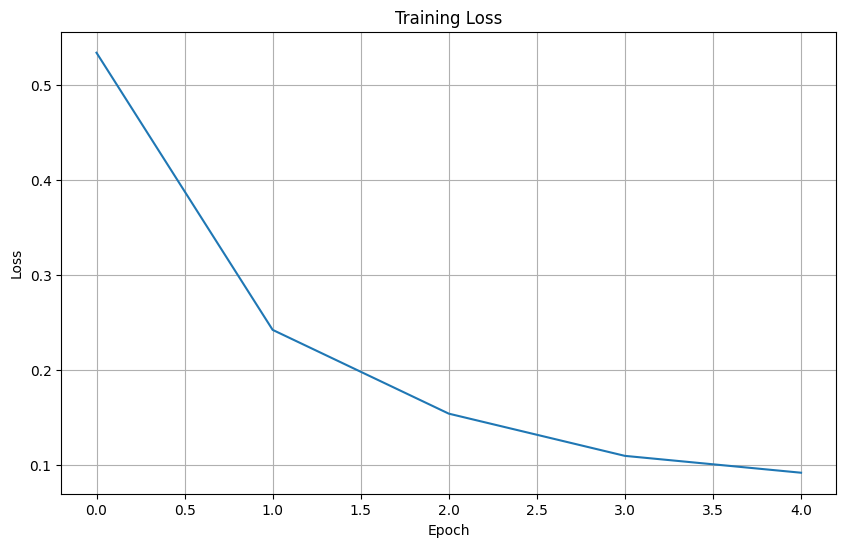

测试集准确率: 0.9780
训练完成！


In [7]:
# 训练函数
def train_gender_classifier(train, test, dict, dict_size):
    # 模型参数
    vocab_size = dict_size
    embed_size = 64
    num_layers = 3
    heads = 8
    qk_dim = 64
    ff_hidden_size = 128
    dropout = 0.1
    max_length = 10
    
    # 创建模型
    model = GenderClassifier(vocab_size, embed_size, num_layers, heads, qk_dim, 
                           ff_hidden_size, dropout, max_length)
    
    # 训练参数
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # 训练循环
    nepoch = 5
    batch_size = 100
    losses = []
    
    for epoch in range(nepoch):
        model.train()
        total_loss = 0
        n_batches = 0
        
        # 随机打乱训练数据
        train_indices = np.random.permutation(len(train))
        
        for i in range(0, len(train), batch_size):
            batch_indices = train_indices[i:i+batch_size]
            batch_names = train.iloc[batch_indices]["dict"].values
            batch_labels = train.iloc[batch_indices]["y"].values
            
            # 转换为tensor
            batch_inputs = []
            batch_labels_tensor = torch.tensor(batch_labels, dtype=torch.float32)
            
            for name in batch_names:
                # 将名字转换为索引序列
                indices = name2index(name, dict)
                # 填充到固定长度
                if len(indices) < max_length:
                    indices.extend([0] * (max_length - len(indices)))
                else:
                    indices = indices[:max_length]
                batch_inputs.append(indices)
            
            batch_inputs = torch.tensor(batch_inputs, dtype=torch.long)
            
            # 前向传播
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs.squeeze(), batch_labels_tensor)
            
            # 反向传播
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            n_batches += 1
            
            if i // batch_size % 10 == 0:
                print(f"Epoch {epoch}, Batch {i // batch_size}, Loss = {loss.item():.4f}")
        
        avg_loss = total_loss / n_batches
        losses.append(avg_loss)
        print(f"Epoch {epoch}, Average Loss = {avg_loss:.4f}")
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
    
    # 测试模型
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for i in range(len(test)):
            name = test.iloc[i]["dict"]
            label = test.iloc[i]["y"]
            
            indices = name2index(name, dict)
            if len(indices) < max_length:
                indices.extend([0] * (max_length - len(indices)))
            else:
                indices = indices[:max_length]
            
            input_tensor = torch.tensor([indices], dtype=torch.long)
            output = model(input_tensor)
            prediction = 1 if output.item() > 0.5 else 0
            
            if prediction == label:
                correct += 1
            total += 1
    
    accuracy = correct / total
    print(f"测试集准确率: {accuracy:.4f}")
    
    return model

# 测试训练函数
print("开始训练性别分类器...")
try:
    model = train_gender_classifier(train, test, dict, dict_size)
    print("训练完成！")
except Exception as e:
    print(f"训练过程中出现错误: {e}")

In [15]:
# 模型测试和预测
def test_model_predictions(model, dict, max_length=10):
    """测试模型对不同名字的预测"""
    model.eval()
    test_names = ["王伟", "李娜", "张强", "刘芳", "陈明", "王美丽", "李英俊",'黄灿',"韩嘉"]
    
    print("模型预测结果:")
    print("-" * 40)
    
    with torch.no_grad():
        for name in test_names:
            # 转换为索引序列
            indices = name2index(name, dict)
            if len(indices) < max_length:
                indices.extend([0] * (max_length - len(indices)))
            else:
                indices = indices[:max_length]
            
            input_tensor = torch.tensor([indices], dtype=torch.long)
            output = model(input_tensor)
            probability = output.item()
            prediction = "女" if probability > 0.5 else "男"
            
            print(f"名字: {name:<8} | 预测性别: {prediction} | 女性概率: {probability:.4f}")

# 运行测试
try:
    test_model_predictions(model, dict)
except NameError:
    print("模型未训练，无法进行预测测试")
    print("请先运行训练代码块")

模型预测结果:
----------------------------------------
名字: 王伟       | 预测性别: 男 | 女性概率: 0.0017
名字: 李娜       | 预测性别: 女 | 女性概率: 0.9984
名字: 张强       | 预测性别: 男 | 女性概率: 0.0019
名字: 刘芳       | 预测性别: 女 | 女性概率: 0.9991
名字: 陈明       | 预测性别: 男 | 女性概率: 0.0051
名字: 王美丽      | 预测性别: 女 | 女性概率: 0.9989
名字: 李英俊      | 预测性别: 男 | 女性概率: 0.1851
名字: 黄灿       | 预测性别: 男 | 女性概率: 0.0016
名字: 韩嘉       | 预测性别: 女 | 女性概率: 0.9682
